In [1]:
%matplotlib inline
import random
import torch
from d2l import torch as d2l

In [2]:
def synthetic_data(w, b, num_examples):
    """
    生成数据 y = Xw + b + 噪声
    :param w: 
    :param b: 
    :param num_examples: 想要的样本数量
    :return: 生成的人造数据集
    """
    X = torch.normal(0, 1, (num_examples, len(w)))  # μ=0,σ=1,n行,len(w)列
    y = torch.matmul(X, w) + b
    y += torch.normal(0, 0.01, y.shape)  # μ=0,σ=1的高斯噪声 
    return X, y.reshape((-1, 1))  # reshape((-1, 1)含义:转变为列向量


true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)
print('features[0:5]:', features[0:5], '\nlabels[0:5]:', labels[0:5])

features[0:5]: tensor([[-0.7798, -1.1066],
        [-0.5464, -0.6717],
        [ 0.5441, -0.7947],
        [ 1.3155, -1.4553],
        [-0.5312, -1.2425]]) 
labels[0:5]: tensor([[ 6.3930],
        [ 5.3784],
        [ 7.9864],
        [11.7800],
        [ 7.3688]])


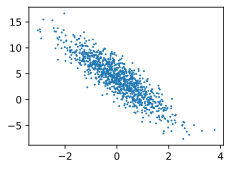

In [3]:
d2l.set_figsize()
d2l.plt.scatter(features[:, 1].detach().numpy(), labels.detach().numpy(), 1);

In [4]:
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))  # 生成[0,1,...,num_examples-1]的列表 (range和list作用见下)
    # 打乱数据
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(indices[i:min(i + batch_size, num_examples)])
        yield features[batch_indices], labels[batch_indices]  # 每次拿10个


"""
Q: 如果剩余样本不够batch_size了,怎么办?
A:  法一: 不管(最常用)
    法二: 丢掉
    法三: 从下一个epoch里拿样本过来补全
"""

batch_size = 10
i = 0
for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    i += 1
    if i == 2:  # 拿两批
        break

tensor([[ 1.1163, -1.1558],
        [-1.3067, -0.4125],
        [ 0.2997, -1.9495],
        [ 0.6885, -0.9853],
        [-0.8426, -0.2701],
        [-0.5212, -1.7877],
        [ 0.2732, -1.0411],
        [ 0.4712,  0.8154],
        [ 0.0390, -0.2498],
        [-0.6170, -0.8860]]) 
 tensor([[10.3607],
        [ 2.9921],
        [11.4284],
        [ 8.9246],
        [ 3.4321],
        [ 9.2347],
        [ 8.2886],
        [ 2.3562],
        [ 5.1268],
        [ 5.9833]])
tensor([[-0.3146,  0.1693],
        [-0.5005, -1.5469],
        [-1.7795,  0.1733],
        [ 1.3514,  0.3079],
        [ 0.3184, -1.4167],
        [-0.6725, -0.0537],
        [-1.2497,  0.3561],
        [ 0.1350, -0.0141],
        [-0.0921, -0.4067],
        [ 1.4915, -0.2513]]) 
 tensor([[3.0155],
        [8.4574],
        [0.0367],
        [5.8849],
        [9.6549],
        [3.0469],
        [0.4807],
        [4.5221],
        [5.3971],
        [8.0226]])


In [5]:
# 模型初始参数
w = torch.normal(0, 0.01, size=(2, 1), requires_grad=True)  # w_0 = [w1,w2]^T
b = torch.zeros(1, requires_grad=True)  # b_0 = 0
"""
Q: 一定要随机初始化吗?
A: 不一定,这个随意,这里只是在模拟torch从零实现罢了
"""


# 定义模型-线性回归模型
def linreg(X, w, b):
    return torch.matmul(X, w) + b


# 定义损失函数-均方损失(L2 Loss)
def squared_loss(y_hat, y):
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2


"""
Q:  为什么用平方损失而不是绝对值损失?
A:  两者其实差别不大,但是绝对值函数是不可导的
    可以使用一个折中的损失函数: 鲁邦损失(Huber's Robust Loss)
    ℓ = |y - y'| - 1/2,  when |y - y_hat| > 1
      = (y-y')²/2,  otherwise
"""


# 定义优化算法-随机梯度下降-SGD
def sgd(params, lr, batch_size):  # SGD: Stochastic Gradient Descent
    """
    下面的context manager作用: 关闭自动梯度计算功能
        (这样,任何张量操作都不会被记录在计算图中，不会影响内存和计算性能
         这种做法常用于模型推理阶段或在进行一些不需要梯度更新的操作时（如更新参数时手动修改）。
         例如，模型的参数更新（如在 SGD 优化中）并不需要计算梯度)
    __enter__: 停止记录计算图（即禁用自动微分）。
    __exit__: 恢复默认的自动梯度计算行为。
    """
    with torch.no_grad():
        # for 把每个参数调优一次
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()
    """
    Q:为什么不用牛顿法(二阶导),收敛不是更快吗?
    A:  1.二阶导计算其实很慢,所以整体收敛速度不一定快; 
        2.统计学来讲,最优解未必是实际最优解,收敛的快慢并不重要
        ✱优化是无底洞的; NFL
    """

In [6]:
lr = 0.03
num_epochs = 3
net = linreg
loss = squared_loss

# for epoch: 每个epoch在整个数据集上迭代一次
for epoch in range(num_epochs):
    # for 批次: 批次数=数据集/批次大小
    for X, y in data_iter((batch_size), features, labels):
        # 每次的损失要基于新的参数重新算
        l = loss(net(X, w, b), y)  # 单个批量的损失
        l.sum().backward()  # 反向传播,每次将新的梯度存在w和b的.grad属性中
        sgd([w, b], lr, batch_size)
    with torch.no_grad():
        # 损失函数: 计算本次epoch的损失值
        # y_hat = net(features, w, b)=<w,x>+b, y = labels
        train_l = loss(net(features, w, b), labels)
        print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')

epoch 1, loss 0.042654
epoch 2, loss 0.000163
epoch 3, loss 0.000048


In [7]:
# 评估
print(f'w的估计误差: {true_w - w.reshape(true_w.shape)}')
print(f'b的估计误差: {true_b - b}')

w的估计误差: tensor([0.0010, 0.0006], grad_fn=<SubBackward0>)
b的估计误差: tensor([0.0005], grad_fn=<RsubBackward1>)


---
### 线性回归的简洁实现 by torch

In [8]:
import numpy as np
import torch
from torch.utils import data
from d2l import torch as d2l

true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = d2l.synthetic_data(true_w, true_b, 1000)


def load_array(data_arrays, batch_size, is_train=True):
    """构造一个PyTorch数据迭代器"""
    dataset = data.TensorDataset(*data_arrays)  # utils from torch
    return data.DataLoader(dataset, batch_size, shuffle=is_train)  # utils from torch


batch_size = 10
data_iter = load_array((features, labels), batch_size)

# iter()-Get an iterator from an object
# next()-Get the next item from the iterator
next(iter(data_iter))

[tensor([[-0.6898, -0.6566],
         [ 0.4046, -0.6435],
         [-1.1201,  0.0627],
         [ 0.6569,  0.9555],
         [-1.1499,  0.2465],
         [ 0.0034, -0.8544],
         [ 0.1276, -0.4196],
         [-0.2602,  1.1881],
         [ 0.8042,  0.3353],
         [-1.5355, -0.4250]]),
 tensor([[ 5.0535],
         [ 7.1921],
         [ 1.7516],
         [ 2.2440],
         [ 1.0654],
         [ 7.1055],
         [ 5.8831],
         [-0.3673],
         [ 4.6611],
         [ 2.5768]])]

In [9]:
# 使用pytorch定义模型
from torch import nn

# 一个线性层 i.e.一个全连接层
# 线性回归<=>简单的单层神经网络
net = nn.Sequential(nn.Linear(2, 1))  # nn.Linear(in_features, out_features)
# Sequential()-A sequential container-可以理解为a list of layers

# 初始化模型参数
net[0].weight.data.normal_(0, 0.01)  # 因为就一层,所以就对net[0]操作即可
net[0].bias.data.fill_(0)

tensor([0.])

In [10]:
# 均方误差函数
loss = nn.MSELoss()

# 优化算法
trainer = torch.optim.SGD(net.parameters(), lr=0.03)

# 训练
num_epochs = 3
for epoch in range(num_epochs):
    for X, y in data_iter:
        l = loss(net(X), y)
        trainer.zero_grad()
        l.backward()
        trainer.step()  # Performs a single optimization step => 这里就是执行一次SGD更新
    l = loss(net(features), labels)
    print(f'epoch {epoch + 1}, loss {l:.5f}')
    """
    在f-string中,
    使用 {l:f} 将 l 格式化为默认的小数形式（通常是六位小数）
    使用 {l:n} 将 l 格式化为根据当前地区设置的数字格式，
        通常包括千位分隔符和适当的小数点符号(比如德国,就是逗号,eg"0,0089")
    自定义保留小数位-使用 {l:.3f} 将 l 格式化为小数点后三位
    """

epoch 1, loss 0.00029
epoch 2, loss 0.00011
epoch 3, loss 0.00011


---
### 其他 & 查漏补缺

In [11]:
# range()和list()
a = range(5)
b = list(a)
a, type(a), b, type(b)

(range(0, 5), range, [0, 1, 2, 3, 4], list)

In [12]:
# python中的yield
def foo():
    print("starting...")
    while True:
        res = yield 4
        print("res:", res)
        yield 5
        print("hhhh:", res)


g = foo()
"""
调用了foo函数,但是因为foo内部有yield(生成器)
所以foo函数并不会真的执行(连第一个print("starting")都不会执行)
而是先得到一个生成器g(相当于一个对象)

用迭代器的方式遍历生成器g,就会执行foo
每次执行都会从上次的yield下一句开始,并在再次遇到"yield xxx"时停止, return xxx

分解:
    ✱第一次遍历g,一直执行到yield 4,然后停止,return了一个4 
     (res=yield 4其实是两句代码:①yield xxx; ②res=xxx;
    *后续每次遍历g,从yield所在的下一句开始执行,到再次yield xxx时停止,return了xxx
     所以其实是走不到res=xxx这句的,相当于话说一半就结束了)

后续每次调用foo,都会
"""
a = next(g)  # 首次调用next(g)时会从foo函数开头往下走
b = next(g)  # 后续调用从yield 4下一句开始往下走,直接遇到新的yield
c = next(g)
d = next(g)
e = next(g)
print(a, b, c, d, e)  # 4 5 4 5 4


starting...
res: None
hhhh: None
res: None
hhhh: None
4 5 4 5 4


\# python中 with 用法

with 后面跟的是一个上下文管理器（Context Manager）<br>
它是一个实现了两个特定方法的对象，用于控制代码块的进入和退出。这两个方法是：<br>
__enter__: 在进入 with 语句时调用的代码。<br>
__exit__: 在 with 语句块结束后调用的代码，无论是否发生异常。

法一: 自己写类实现这俩方法

    class MyContextManager:
        def __enter__(self):
            print("Entering the context...")
            # 可以返回一些对象作为上下文中使用
            return self
    
        def __exit__(self, exc_type, exc_value, traceback):
            # 退出上下文时执行，无论是否发生异常
            print("Exiting the context...")
            if exc_type is not None:
                print(f"An exception occurred: {exc_value}")
            return False  # 如果返回 True，异常会被抑制；返回 False 则继续抛出异常
    
    # 使用自定义上下文管理器
    with MyContextManager() as manager:
        print("Inside the with block")
        # 可以放置一些逻辑，比如资源使用、操作
        # raise ValueError("An error occurred")  # 模拟异常  
法二: 使用 contextlib 中的 @contextmanager 装饰器

    from contextlib import contextmanager

    @contextmanager
    def my_context():
        print("Entering the context...")
        yield  # yield 之前的代码相当于 __enter__
        print("Exiting the context...")  # yield 之后的代码相当于 __exit__
    
    # 使用自定义上下文管理器
    with my_context():
        print("Inside the with block")
        # raise ValueError("An error occurred")  # 模拟异常
        
with有点类似Java中的 ①面向切面编程（AOP）②try-with-resources ③ThreadLocal<br>
不同点: AOP更加强调在方法调用的切入，而上下文管理器则主要用于代码块执行的资源管理和上下文管理

再举一个例子 

    with open('file.txt', 'r') as f:
        content = f.read()  # 文件自动关闭
-----vs java:

    import java.io.*;
    
    public class Main {
        public static void main(String[] args) {
            try (BufferedReader br = new BufferedReader(new FileReader("file.txt"))) {
                String line;
                while ((line = br.readLine()) != null) {
                    System.out.println(line);
                }
            } catch (IOException e) {
                e.printStackTrace();
            }
        }
    }
